**Bloque 2**: Arquitecturas Cuánticas  
**Alumno**: Álvaro Manuel Aparicio Morales  
*I Certificado de Extensión Universitaria en Computación Cuántica*

<a id='sec_Notebooks_Circ_1_qubit'></a>
# Circuitos de un qúbit
$\newcommand{\ket}[1]{|#1\rangle}$

In [1]:
# No olvidar que en "google colab" hay que instalar qiskit

########################
# Instala versión 0.45.2
########################
# Importante, poner qiskit-aer en la misma linea de "pip install" para que coja la versión adecuada
try:
    import google.colab
    print("In colab, let's install things...")
    #
    !pip install qiskit[visualization]==0.45.2 qiskit-aer qiskit-ibm-runtime
except ImportError:
    print("NOT in colab")

NOT in colab


In [2]:
from IPython.display import display, Latex, Markdown
from matplotlib import pyplot as plt
import scipy.linalg as la
import numpy as np

In [3]:
from qiskit.circuit import QuantumRegister, ClassicalRegister,QuantumCircuit
from qiskit_aer import AerSimulator
from qiskit import transpile
from qiskit.quantum_info import Statevector, schmidt_decomposition
from qiskit.visualization import plot_histogram, plot_bloch_multivector, array_to_latex  

In [4]:
# Utilería acumulada

# Definimos una función para visualizar el estado y la esfera a la vez
# Permite escalar la(s) esferas(s) con 'inches' pulgadas, si este parámetro
# no se pone, se dibuja al tamaño por defecto
# Si se pone 0, no se dibuja la esfera
def my_display_state_vector(psi, inches=None, prefix=r"|\psi\rangle = "):
    d_latex = psi.draw('latex', prefix=prefix)
    display(d_latex)
    #
    d_bloch = psi.draw('bloch')
    if isinstance(inches, (int,float)):
        if inches > 0:
            d_bloch.set_size_inches(inches, inches, forward=True)
            display(d_bloch)
    else:
        display(d_bloch)



<a id='nb03_sec1'></a>
## Iniciar un circuito a partir del vector de estado

En este ejercicio vamos a constuir un circuito de un qubit meramente inicializado con un valor arbitrario y realizaremos su simulación

<IPython.core.display.Latex object>

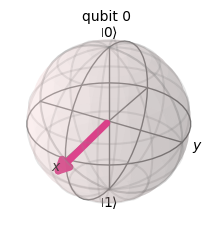

In [5]:
# Iniciando un simple circuito sin puertas

# Vamos a generar un vector de estado de un qubit a un estado aleatorio
rm = np.random.rand(2,1) + np.random.rand(2,1)*1j
rm = rm/la.norm(rm) # Normalizar 
initial_state = Statevector(rm)

# Vamos a mostar este estado con 2 decimales
# Recordar que los States vectors se admiten no normalizados, 
# otra cosa es que no sean válidos
my_display_state_vector(Statevector([np.round(initial_state[0],2), np.round(initial_state[1],2)]), 2.5) 

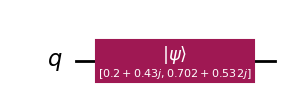

In [6]:
# Creamos un circuito cuántico de 1 qubit
# con una mera inicialización y lo mostramos
qc = QuantumCircuit(1)
qc.initialize(initial_state)

# Mostramos el circuito en estilo matplotlib (mpl)
fig = qc.draw('mpl', style="iqp")
display(fig)

Obsérvese que el método `QuantumCircuit.draw('mpl')` genera una figura de Matplotlib, y la hemos almacenado en una variable, por lo que la podemos usar con los métodos típicos de Matplotlib como el `savefig()` para guardar la figura en un fichero

In [7]:
# Salvemos la figura con el circuito en un fichero y comprobemos
# que se ha generado

#filename = "/tmp/Fig_circuit_initial_state.png"
#fig.savefig(filename)
#!ls -l $filename # Chequear que el fichero se ha generado, escapando al shell

c:\Users\zzalv\Desktop\Cursos\2024\QuantUMA\.venv\Lib\site-packages\qiskit\visualization\circuit\matplotlib.py:266: FutureWarning: The default matplotlib drawer scheme will be changed to "iqp" in a following release. To silence this warning, specify the current default explicitly as style="clifford", or the new default as style="iqp".
  self._style, def_font_ratio = load_style(self._style)


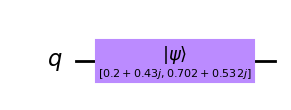

In [8]:
qc.draw(output="mpl")

<div style="background-color:#c8e6c9">
<hr>
<b>Ejercicio:</b>
    
Lee en la documentación en que otros formatos se puede _dibujar_ el ciruito (texto, Latex,...) y pruébalos
<hr>
</div>

In [9]:
qc.draw()

┌───────────────────────────────────────────────┐
q: ┤ Initialize(0.19978+0.42957j,0.70185+0.53195j) ├
   └───────────────────────────────────────────────┘

In [ ]:
qc.draw(output="latex")

c:\Users\zzalv\Desktop\Cursos\2024\QuantUMA\.venv\Lib\site-packages\qiskit\visualization\circuit\latex.py:154: FutureWarning: The default matplotlib drawer scheme will be changed to "iqp" in a following release. To silence this warning, specify the current default explicitly as style="clifford", or the new default as style="iqp".
  self._style, _ = load_style(style)


Para simular un circuito con el simulador _Aer_ (simulador incluido en el ecosistema Qiskit) seguiremos los siguientes pasos:
- Preparar una **instancia del simulador** Aer (hay varios tipos de simulación disponibles)
- **Transpilar** el circuito (es similar a la compilación, el circuito se optimiza y se transforma en un circuito equivalente capaz de ser ejecutado en el HW cuántico objetivo)
- **Ejecutar** (puesto que el resultado es probabilístico, generalmente la simulación se repite un número de veces que denominamos _shots_)
- Obtener el **resultado**:
    - En estos primeros ejemplos usaremos un _God mode_ que permite ver el estado resultante, para ello se añade una _sonda_ en la cual se almacena el estado final de la simulación
    - En la práctica solo tenemos el conteo de las mediciones posibles, sobre las que estimaremos las probabilidades

In [8]:
# Para poder observar el estado final de la simulación (cosa que
# en un computador cuántico real es imposible) añadimos una "sonda"
# de simulación
qcnew = qc.copy()   # Hacemos una copia del cicuito original para añadir la "sonda"
qcnew.save_statevector()

# Sugerencia: dibuja el nuevo circuito, ¿qué ha pasado?


In [9]:
# Generamos una instancia del simulador;
# con "method" le especificamos el método de simulación
simulador = AerSimulator(method = 'statevector')

# También podemos llamar primero a la clase del simulador sin
# pasarle argumentos y después añadir las opciones:
# simulador = AerSimulator()
# sim.set_options(method = 'statevector')

# Transpilamos (para un ejemplo tan sencillo ni siquiera haría falta
qct = transpile(qcnew, backend = simulador)

# Ejecutamos la simulación, para ver el estado sería 
# suficiente con 1 shot, pero pongamos más
job = simulador.run(qct, shots = 1)
result = job.result()

<IPython.core.display.Latex object>

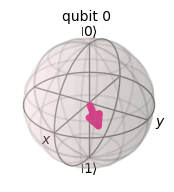

In [10]:
# Como pusimos la sonda, vamos a tomar el estado final aunque
# en la realidad esto no es posible
final_state = result.get_statevector()

# Veamos cómo es
my_display_state_vector(final_state, 2)

In [11]:
# Si el simulador simula bien, debemos haber obtenido el
# mismo estado que inicalmente
assert(final_state == initial_state)

In [12]:
# Del objeto resultado, también podemos ver la probabilidad
# de medir un |0> o un |1>
# (aunque esto lo haremos luego poniendo medidores!!)
# Como no hemos puesto medidores es un resultado, ideal, a partir
# del cuadrado de las amplitudes de |0> y |1>

counts_ideal = result.get_counts(0)
display(counts_ideal)

{'0': 0.513877273903865, '1': 0.486122726096135}

In [13]:
# Comprobemos que el resultado del simulador coinciden
# con el cuadrado de las amplitudes
p0 = np.abs(initial_state[0])**2
p1 = np.abs(initial_state[1])**2
print(" p0={0}\n p1={1}".format(p0,p1))

 p0=0.5138772739038648
 p1=0.48612272609613494


<a id='nb03_sec2'></a>
## Puertas de un qubit

In [14]:
# Definamos alguna utilería

# Función para simular un cirucito dado:
# devuelve esta terna (estado final, cuenta, resultado del job)
def my_get_circuit_state(qcirc_in, shots=1):
    # Instancia del simulador
    sim = AerSimulator(method = "statevector")
    
    # Hacemos una copia ya que vamos a cambiar el objeto circuito
    qcirc = qcirc_in.copy()
    
    # Ponemos el "probe" para el vector de estado al final
    # del cirucito dado
    # ojo! el circuito no debe de tener un "save_statevector" ya!
    qcirc.save_statevector()
    
    # Hacemos una simulación y obtenemos los resultados
    qobj = transpile(qcirc, sim)
    result = sim.run(qobj, shots=shots).result()
    state = result.get_statevector()
    counts_ideal = result.get_counts()
    
    return state, counts_ideal, result


<a id='sec_Notebooks_Circ_1_qubit_1.2'></a>
### Puerta X

Veamos ahora un ejemplo de un circuito con la puerta $X$ para ver su acción

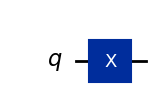

In [15]:
# Creamos el circuito de 1 solo qubit
circuit_X = QuantumCircuit(1)

# Añadimos la puerta X al primer (y único) qúbit
# Nótese que por defecto el estado inicial si no se indica es |0>
circuit_X.x(0)

# Podemos dibujarlo en modo texto
#print(circuit_X.draw(output='text'))

# Podemos dibujarlo como figura de matplolib
fig = circuit_X.draw(output='mpl',  style="iqp") # mpl es de Matplolib

# Podemos guardar la figura en fichero
#fig.savefig("/tmp/Fig_circuit_X.png")
# Invocar al sistema, comprobar que el fichero se ha creado
#!ls -l "/tmp/Fig_circuit_X.png"

# Si queremos mostramos el circuito
display(fig)

<IPython.core.display.Latex object>

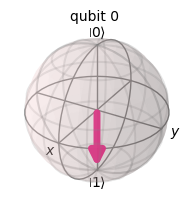

{'1': 1.0}

In [16]:
# Usemos nuestra función de utilería que simula y nos da el estado final
state, p_ideal, r = my_get_circuit_state(circuit_X)

# Visualicemos el estado y las probabilidades
my_display_state_vector(state,2.2, r"\Psi_{out X}=")
display(p_ideal)


<a id='sec_Notebooks_Circ_1_qubit_1.3'></a>
### Puerta H

Veamos ahora un ejemplo de un circuito con la puerta $H$ para ver su acción

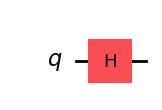

In [17]:
# Creamos el circuito de 1 solo qubit
circuit_H = QuantumCircuit(1)

# Añadimos la puerta X al primer (y único) qúbit
# Nótese que por defecto el estado inicial si no se indica es |0>
circuit_H.h(0)

# Podemos dibujarlo en modo texto
#print(circuit_H.draw(output='text'))

# Podemos dibujarlo como figura de matplolib
fig = circuit_H.draw(output='mpl',  style="iqp") # mpl es de Matplolib

# Podemos guardar la figura en fichero
#Fig.savefig("/tmp/Fig_circuit_H.png")
# Invocar al sistema, comprobar que el fichero se ha creado
#!ls -l "/tmp/Fig_circuit_H.png"

# Si queremos mostramos el circuito
display(fig)

<IPython.core.display.Latex object>

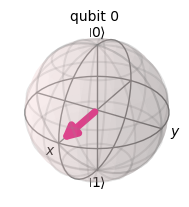

{'0': 0.5, '1': 0.5}

In [18]:
# Usemos nuestra función de utilería que simula y nos da el estado final
state, p_ideal, r = my_get_circuit_state(circuit_H)

# Visualicemos el estado y las probabilidades
my_display_state_vector(state,2.2, r"\Psi_{out H}=")
display(p_ideal)

Como podemos ver, ahora aproximadamente la mitad de las veces obtenemos $| 0 \rangle$ y la otra mitad obtenemos $| 1 \rangle$. Esto es debido a que 
$$
H |0  \rangle = \frac{1}{\sqrt{2}} \left(| 0 \rangle + | 1 \rangle \right)
$$
Recordemos que la probabilidad de medir cada estado es igual al módulo cuadrado de su amplitud (del coeficiente que acompaña al estado)

<a id='sec_Notebooks_Circ_1_qubit_1.3'></a>
### Circuito de un qubit con varias puertas

Veamos ahora un ejemplo de un circuito con varias puertas
Y vamos a poner varios "probes" para ver los valores intermedios del vector de estado

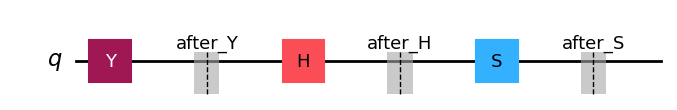

In [19]:
# Creamos el circuito de 1 solo qubit
circuit_M = QuantumCircuit(1)

# Añadimos la puerta X al primer (y único) qúbit
# Nótese que por defecto el estado inicial si no se indica es |0>
circuit_M.y(0)
circuit_M.save_statevector(label='after_Y')    # Probe para statevector intermedio
circuit_M.h(0)
circuit_M.save_statevector(label='after_H')    # Probe para statevector intermedio
circuit_M.s(0)
circuit_M.save_statevector(label='after_S')    # Probe para statevector intermedio

# Podemos dibujarlo en modo texto
#print(circuit_M.draw(output='text'))

# Podemos dibujarlo como figura de matplolib
fig = circuit_M.draw(output='mpl',  style="iqp") # mpl es de Matplolib

# Si queremos mostramos el circuito
display(fig)

<IPython.core.display.Latex object>

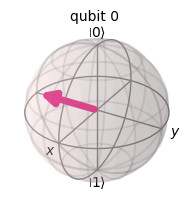

{'0': 0.5, '1': 0.5}

In [20]:
# Usemos nuestra función de utilería que simula y nos da el estado final
state, p_ideal, result = my_get_circuit_state(circuit_M)

# Visualicemos el estado y las probabilidades finales
my_display_state_vector(state,2.2, r"\Psi_{out}=")
display(p_ideal)

In [21]:
# Veamos los estados intermedios
# Esto es un 'dirty trick'
result_state_0 = result.data(0)['after_Y']
result_state_1 = result.data(0)['after_H']
result_state_2 = result.data(0)['after_S']

my_display_state_vector(result_state_0, 0, r"\Psi_{after Y}=")
my_display_state_vector(result_state_1, 0, r"\Psi_{after H}=")
my_display_state_vector(result_state_2, 0, r"\Psi_{after S}=")

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

In [22]:
import qiskit
from qiskit_aer import AerSimulator
import qiskit.tools.jupyter
%qiskit_version_table